In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Path to dataset
dataset_path = "PlantVillage"

# Check classes
classes = os.listdir(dataset_path)
print("Classes:", classes)


Classes: ['.ipynb_checkpoints', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage']


In [3]:
IMG_SIZE = 128
data = []
labels = []

for category in classes:
    path = os.path.join(dataset_path, category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append(resized)
            labels.append(category)
        except Exception as e:
            pass

data = np.array(data) / 255.0
labels = np.array(labels)


In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("Encoded Labels Shape:", labels.shape)


Encoded Labels Shape: (2475, 1)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [6]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)


In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\parth\OneDrive\Desktop\tensorflow\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,517,060 (24.86 MB)

 Trainable params: 6,517,060 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.utils import to_categorical

# Suppose you have 4 classes
num_classes = 4

y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print(y_train.shape)  # Should be (num_samples, 4)


(1980, 4)


In [9]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",   # or sparse_categorical_crossentropy
    metrics=["accuracy"]
)


In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks=[early_stop]
)

C:\Users\parth\OneDrive\Desktop\tensorflow\tfvenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7263 - loss: 0.5797 - val_accuracy: 0.8949 - val_loss: 0.2902
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 48s 764ms/step - accuracy: 0.8793 - loss: 0.3478 - val_accuracy: 0.8889 - val_loss: 0.3402
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 711ms/step - accuracy: 0.8783 - loss: 0.3189 - val_accuracy: 0.9212 - val_loss: 0.2146
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 49s 787ms/step - accuracy: 0.9263 - loss: 0.2272 - val_accuracy: 0.9172 - val_loss: 0.2533
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 698ms/step - accuracy: 0.9389 - loss: 0.2284 - val_accuracy: 0.9455 - val_loss: 0.1444
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 45s 717ms/step - accuracy: 0.9576 - loss: 0.1568 - val_accuracy: 0.9596 - val_loss: 0.1055
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 684ms/step - accuracy: 0.9591 - loss: 0.1401 - val_accuracy: 0.9576 - val_loss: 0.1183
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 690ms/step - accuracy: 0.9510 - loss: 0.1411 - val_accurac

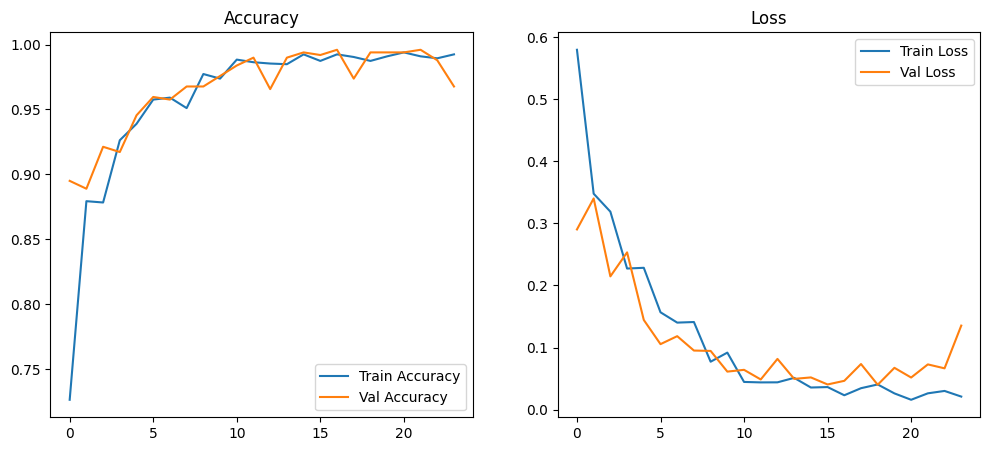

In [15]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [16]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9677 - loss: 0.1353
Test Accuracy: 96.77%


In [17]:
model.save("crop_disease_model.h5")


In [19]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found or cannot be opened: {img_path}")
    
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    class_idx = np.argmax(pred)
    print("Predicted Class:", lb.classes_[class_idx])


In [20]:
import os
print(os.path.abspath("PlantVillage/Tomato___Bacterial_spot/001.jpg"))


C:\Users\parth\OneDrive\Desktop\tensorflow\PlantVillage\Tomato___Bacterial_spot\001.jpg
